In [1]:
%pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   --- ------------------------------------ 3.4/39.0 MB 20.2 MB/s eta 0:00:02
   ---- ----------------------------------- 4.7/39.0 MB 11.9 MB/s eta 0:00:03
   ----- ---------------------------------- 5.8/39.0 MB 9.5 MB/s eta 0:00:04
   ------ --------------------------------- 6.8/39.0 MB 8.1 MB/s eta 0:00:04
   -------- ------------------------------- 7.9/39.0 MB 7.5 MB/s eta 0:00:05
   -------- ------------------------------- 8.7/39.0 MB 6.8 MB/s eta 0:00:05
   ---------- ----------------------------- 10.0/39.0 MB 6.7 MB/s eta 0:00:05
   ----------- ---------------------------- 11.0/39.0 MB 6.6 MB/s eta 0:00:05
   ------------ --------------------------- 11.8/39.0 MB 6.3 MB/s eta 0:00:05
   ------------ --------------------------- 12.3/39.0 MB 6.2 MB/s eta 0:00:05
   ------------- -------------------------- 13.4/39.0 MB 5.9 MB/s eta 0:00:05
   -------------- ------------------------- 14.4/39.0 MB 5.8 MB/s eta 0:00:0

In [2]:
import torch

if torch.cuda.is_available():
    print("✅ Success! CUDA is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ Failed. CUDA is still not available.")

✅ Success! CUDA is available!
GPU Name: NVIDIA GeForce GTX 1650


✅ Success! CUDA is available!
GPU Name: NVIDIA GeForce GTX 1650
➡️ Splitting data based on 'patient_id' to prevent data leakage...
Training samples: 2277 | Validation samples: 585
Number of unique patients in training set: 998
Number of unique patients in validation set: 250
➡️ Creating weighted sampler to address class imbalance...
Class counts: {'benign': 1340, 'malignant': 937}
Class weights: tensor([0.0007, 0.0011])
➡️ Creating sample weights...
✅ WeightedRandomSampler created successfully.
➡️ Creating DataLoaders...
Valid training samples: 2277
Valid validation samples: 585
Valid test samples: 704
✅ Setup complete, ready to train!
Using device: cuda
✅ Model, loss function, and optimizer are ready.
✅ Grad-CAM class and overlay function are defined.
Calculated Class Weights : [0.84962687 1.21504803]
🚀 Starting model training...



--- Epoch 1/10 ---
Time: 428.77s
Train Loss: 0.7207 | Train Acc: 0.5512
Val Loss:   0.6575 | Val Acc:   0.6017
✅ New best model saved!



--- Epoch 2/10 ---
Time: 414.00s
Train Loss: 0.6853 | Train Acc: 0.5894
Val Loss:   0.6552 | Val Acc:   0.6393
✅ New best model saved!



--- Epoch 3/10 ---
Time: 351.48s
Train Loss: 0.6718 | Train Acc: 0.6047
Val Loss:   0.6704 | Val Acc:   0.6068



--- Epoch 4/10 ---
Time: 356.27s
Train Loss: 0.6425 | Train Acc: 0.6443
Val Loss:   0.6991 | Val Acc:   0.5932



--- Epoch 5/10 ---
Time: 382.31s
Train Loss: 0.6304 | Train Acc: 0.6522
Val Loss:   0.6321 | Val Acc:   0.6581
✅ New best model saved!



--- Epoch 6/10 ---
Time: 399.79s
Train Loss: 0.6045 | Train Acc: 0.6737
Val Loss:   0.6346 | Val Acc:   0.6513



--- Epoch 7/10 ---
Time: 413.41s
Train Loss: 0.6254 | Train Acc: 0.6482
Val Loss:   0.6671 | Val Acc:   0.6120



--- Epoch 8/10 ---
Time: 407.86s
Train Loss: 0.5853 | Train Acc: 0.6873
Val Loss:   0.6383 | Val Acc:   0.6359



--- Epoch 9/10 ---
Time: 429.29s
Train Loss: 0.5861 | Train Acc: 0.6816
Val Loss:   0.6040 | Val Acc:   0.6855
✅ New best model saved!



--- Epoch 10/10 ---
Time: 351.32s
Train Loss: 0.5667 | Train Acc: 0.6974
Val Loss:   0.6464 | Val Acc:   0.6222

Training finished in 65.61 minutes.
Best validation accuracy: 0.6855


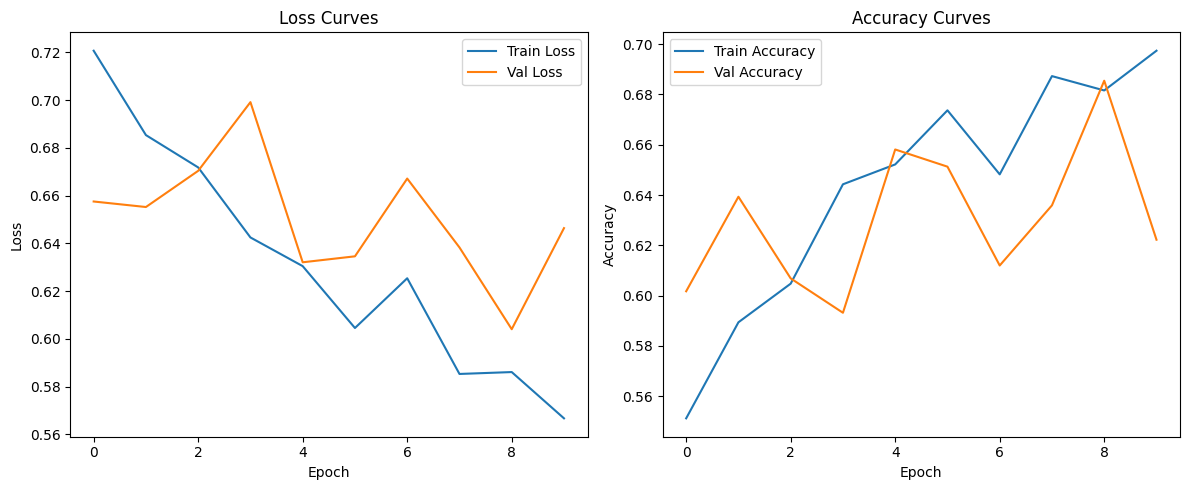


🔍 Generating CONDITIONAL Grad-CAM visualization...
Prediction: Malignant. Generating Grad-CAM heatmap...


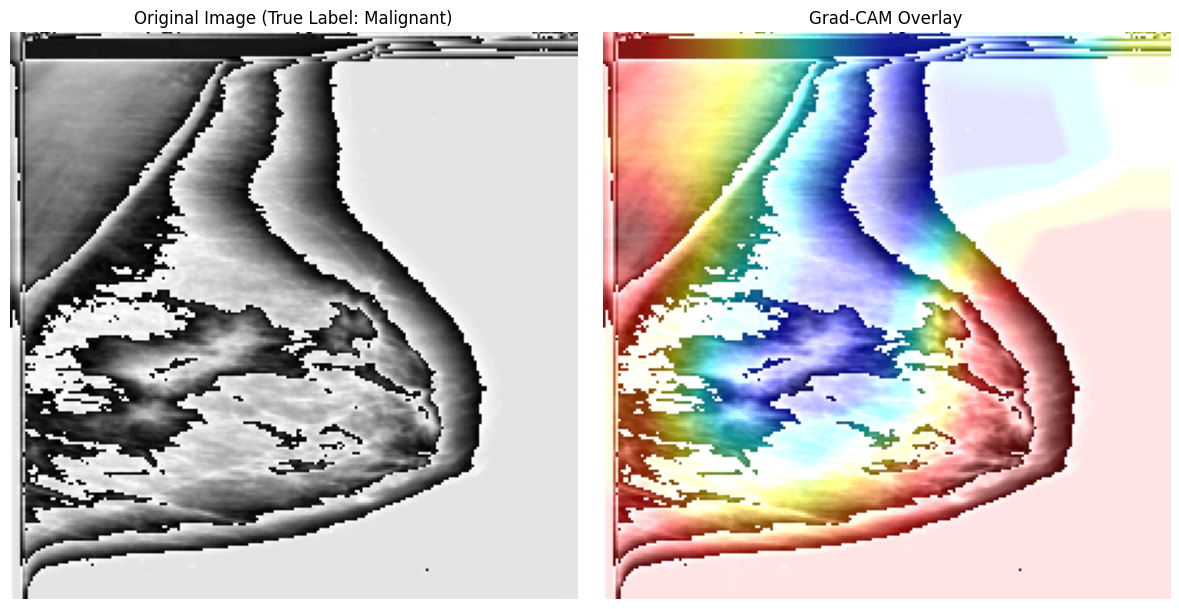

✅ Conditional Grad-CAM analysis complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import WeightedRandomSampler
import time
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm import tqdm
# Checking if CUDA is available
if torch.cuda.is_available():
    print("✅ Success! CUDA is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ Failed. CUDA is still not available.")



'''Data Augmentation and DataLoader Setup'''



# 1. Transformations for the TRAINING Set
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

# 2. Transformations for the VALIDATION Set
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

# 3. Custom Dataset class with filtering of bad samples inside __getitem__
class MammogramDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = {'benign': 0, 'malignant': 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        try:
            img = Image.open(row['image_path']).convert('L')
            if self.transform:
                img = self.transform(img)
            label = self.label_map[row['label']]
            return img, label
        except Exception as e:
            print(f"⚠️  Error loading image {row['image_path']} at index {idx}: {e}")
            # Return None to signal bad sample, handle in collate_fn or dataloader
            return None, None

# 4. Custom collate_fn to filter out None samples
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch:
        return torch.tensor([]), torch.tensor([])
    
    return torch.utils.data.default_collate(batch)

# 5. splitting data into training and validation sets
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
BASE_DIR = r'C:\hopescan'
train_df = pd.read_csv(f'{BASE_DIR}/processed_train_data.csv')
test_df = pd.read_csv(f'{BASE_DIR}/processed_test_data.csv')

print("➡️ Splitting data based on 'patient_id' to prevent data leakage...")
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_indices, val_indices = next(splitter.split(train_df, groups=train_df['patient_id']))

# 6. Create the final training and validation DataFrames
train_df_split = train_df.iloc[train_indices]
val_df_split = train_df.iloc[val_indices]

print(f"Training samples: {len(train_df_split)} | Validation samples: {len(val_df_split)}")
print(f"Number of unique patients in training set: {train_df_split['patient_id'].nunique()}")
print(f"Number of unique patients in validation set: {val_df_split['patient_id'].nunique()}")

# 7. Creating Dataset
train_dataset = MammogramDataset(train_df_split, transform=train_transforms)
val_dataset = MammogramDataset(val_df_split, transform=val_transforms)
test_dataset = MammogramDataset(test_df, transform=val_transforms)

print("➡️ Creating weighted sampler to address class imbalance...")
class_counts = train_df_split['label'].value_counts()
class_weights = torch.tensor([1.0 / class_counts['benign'], 1.0 / class_counts['malignant']]).float()
print(f"Class counts: {class_counts.to_dict()}")
print(f"Class weights: {class_weights}")

# 8. Creating sample weights for each training sample
print("➡️ Creating sample weights...")
labels = train_df_split['label'].map(train_dataset.label_map).tolist()
sample_weights = [class_weights[label].item() for label in labels]


# Create the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print("✅ WeightedRandomSampler created successfully.")

# 9. Create DataLoaders

print("➡️ Creating DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)

print(f"Valid training samples: {len(train_dataset)}")
print(f"Valid validation samples: {len(val_dataset)}")
print(f"Valid test samples: {len(test_dataset)}")
print("✅ Setup complete, ready to train!")







'''Model, Loss Function, and Optimizer Setup'''




LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load the pretrained DenseNet-121 model
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Get the number of input features for the classifier
num_features = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # ADDED: Dropout layer to prevent overfitting
    nn.Linear(num_features, 2) # Your original final layer for 2 classes
)

# Moving the model to the selected device (GPU or CPU)
model = model.to(DEVICE)

# Loss Function and Optimizer
# CrossEntropyLoss is perfect for multi-class (including binary) classification
criterion = nn.CrossEntropyLoss()

# Adam is a great all-around optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning Rate Scheduler to reduce learning rate based on validation loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

print("✅ Model, loss function, and optimizer are ready.")




""" Training and Evaluation Functions """

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Wrap the dataloader with tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc="Training Epoch", leave=False)
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        if inputs.size(0) == 0:
            continue
            
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        # Update the progress bar with live loss and accuracy
        current_loss = running_loss / total_samples
        current_acc = (correct_predictions.double() / total_samples).item()
        progress_bar.set_postfix({"Loss": f"{current_loss:.4f}", "Acc": f"{current_acc:.4f}"})
        
    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_predictions.double() / total_samples).item()
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Disable gradient calculations
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if inputs.size(0) == 0:
                continue
                
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    return epoch_loss, epoch_acc.item()

# Implementing Grad-CAM class to generate and visualize heatmaps showing which parts of an image the model focused on for its prediction.

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks to capture the gradients and activations
        # from the target layer during the backward and forward passes.
        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_full_backward_hook(self._backward_hook)

    def _backward_hook(self, module, grad_in, grad_out):
        """Stores the gradients flowing out of the target layer."""
        self.gradients = grad_out[0]

    def _forward_hook(self, module, input, output):
        """Stores the activations from the target layer."""
        self.activations = output

    def generate_heatmap(self, input_tensor, class_idx=None):
        """Generates the heatmap for a given input tensor."""
        # Make a forward pass to get the model's output
        output = self.model(input_tensor.unsqueeze(0))
        
        # If no class index is specified, use the model's top prediction
        if class_idx is None:
            class_idx = torch.argmax(output).item()
            
        # Zero out any existing gradients and perform a backward pass
        # from the target class to get the gradients at the target layer.
        self.model.zero_grad()
        output[0][class_idx].backward()
        
        # Pool the gradients across the spatial dimensions and weight the activation channels.
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.squeeze(0)
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
            
        # Average the channels to create the heatmap, apply ReLU, and normalize.
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0) # ReLU
        heatmap /= np.max(heatmap) # Normalize to [0, 1]
        
        return heatmap

def overlay_heatmap(original_img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    if isinstance(original_img, torch.Tensor):
        # Convert tensor to a displayable PIL image
        original_img = transforms.ToPILImage()(original_img.cpu())

    original_img = np.array(original_img)
    
    # Resize heatmap and apply a colormap
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    
    # Blend the heatmap with the original image
    superimposed_img = heatmap * alpha + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    return superimposed_img

def analyze_with_conditional_gradcam(model, grad_cam, img_tensor, device):
    """Analyzes an image and generates Grad-CAM only if the prediction is malignant."""
    model.eval()
    
    # 1. Get the model's prediction first
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        prediction_idx = torch.argmax(output, dim=1).item()
        
    # 2. Check the prediction before running Grad-CAM
    if prediction_idx == 1: # If prediction is 'Malignant'
        print("Prediction: Malignant. Generating Grad-CAM...")
        heatmap = grad_cam.generate_heatmap(img_tensor.to(device))
        overlay = overlay_heatmap(img_tensor, heatmap)
        
        # Plot the results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(transforms.ToPILImage()(img_tensor.cpu()), cmap='gray')
        ax1.set_title("Original Image")
        ax1.axis('off')
        ax2.imshow(overlay)
        ax2.set_title("Grad-CAM Overlay")
        ax2.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Prediction: Benign. No heatmap generated.")

print("✅ Grad-CAM class and overlay function are defined.")

# --- 1. Compute Class Weights ---
# Get all labels from your training set to calculate weights
train_labels = train_df_split['label'].map({'benign': 0, 'malignant': 1}).values

# Calculate weights that are inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

print(f"Calculated Class Weights : {class_weights}")

# Training Loop
NUM_EPOCHS = 10
best_val_acc = 0.0
train_losses, train_accs, val_losses, val_accs = [], [], [], []

print("🚀 Starting model training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    
    # Run one epoch of training and validation
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    epoch_duration = time.time() - epoch_start_time
    
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    print(f"Time: {epoch_duration:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Save the model if validation accuracy has improved
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save the model's state dictionary
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        print("✅ New best model saved!")

total_training_time = time.time() - start_time
print(f"\nTraining finished in {total_training_time / 60:.2f} minutes.")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# grad-cam visualization example
print("\n🔍 Generating CONDITIONAL Grad-CAM visualization...")

# 1. Load your best saved model and set it to evaluation mode
model.load_state_dict(torch.load('best_model_checkpoint.pth'))
model.to(DEVICE) # Ensure model is on the correct device
model.eval()

# 2. Initialize the GradCAM object
grad_cam = GradCAM(model=model, target_layer=model.features.denseblock4)

# 3. Select an image to analyze from your validation set
img_tensor, label = val_dataset[30] # You can change the index (e.g., 15, 20) to test

# 4. Get the model's prediction for the selected image FIRST
with torch.no_grad():
    # Add a batch dimension and move to the correct device
    output = model(img_tensor.unsqueeze(0).to(DEVICE))
    prediction_idx = torch.argmax(output, dim=1).item()

# 5. Check if the prediction is 'Malignant' before running Grad-CAM
if prediction_idx == 1:
    print("Prediction: Malignant. Generating Grad-CAM heatmap...")
    
    # a. Generate the heatmap and create the overlay
    heatmap = grad_cam.generate_heatmap(img_tensor.to(DEVICE))
    overlay = overlay_heatmap(img_tensor, heatmap)
    
    # b. Plot the original image and the Grad-CAM overlay
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(transforms.ToPILImage()(img_tensor.cpu()), cmap='gray')
    ax1.set_title(f'Original Image (True Label: {"Malignant" if label == 1 else "Benign"})')
    ax1.axis('off')
    
    ax2.imshow(overlay)
    ax2.set_title('Grad-CAM Overlay')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    # This block runs if the prediction is 'Benign'
    print(f"Prediction: Benign. No heatmap is necessary.")
    print(f"(True label for this image was: {'Malignant' if label == 1 else 'Benign'})")

print("✅ Conditional Grad-CAM analysis complete.")
